In [1]:
using DIVAnd
using PyPlot
using Proj4
using DelimitedFiles
using PyCall
using Dates
using NCDatasets
include("../scripts/PhytoInterp.jl")
include("../scripts/PhytoInterpPlot.jl")
doplot = true

true

## Files and directories

In [2]:
figdir = "../product/figures/greaterNorthSea"
outputdir = "../product/greaterNorthSea/"
datadir = "../data/"
datafile = joinpath(datadir, "specs4Diva.csv")
isdir(datadir) ? " " : mkpath(datadir)
isdir(figdir) ? " " : mkpath(figdir)
isdir(outputdir) ? " " : mkpath(outputdir)
# change the file URL
#isfile(datafile) ? @info("File already downloaded") : download("https://dox.ulg.ac.be/index.php/s/VgLglubaTLetHzc/download", datafile)

" "

## Prepare mask
### Interpolation grid

In [3]:
longrid = -16.:0.1:9.
latgrid = 45.:0.1:66.

45.0:0.1:66.0

### Download file

In [4]:
bathname = joinpath(datadir, "gebco_30sec_4.nc")
if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/RSwm4HPHImdZoQP/download", bathname)
else
    @info("Bathymetry file already downloaded")
end

┌ Info: Bathymetry file already downloaded
└ @ Main In[4]:5


### Read bathymetry

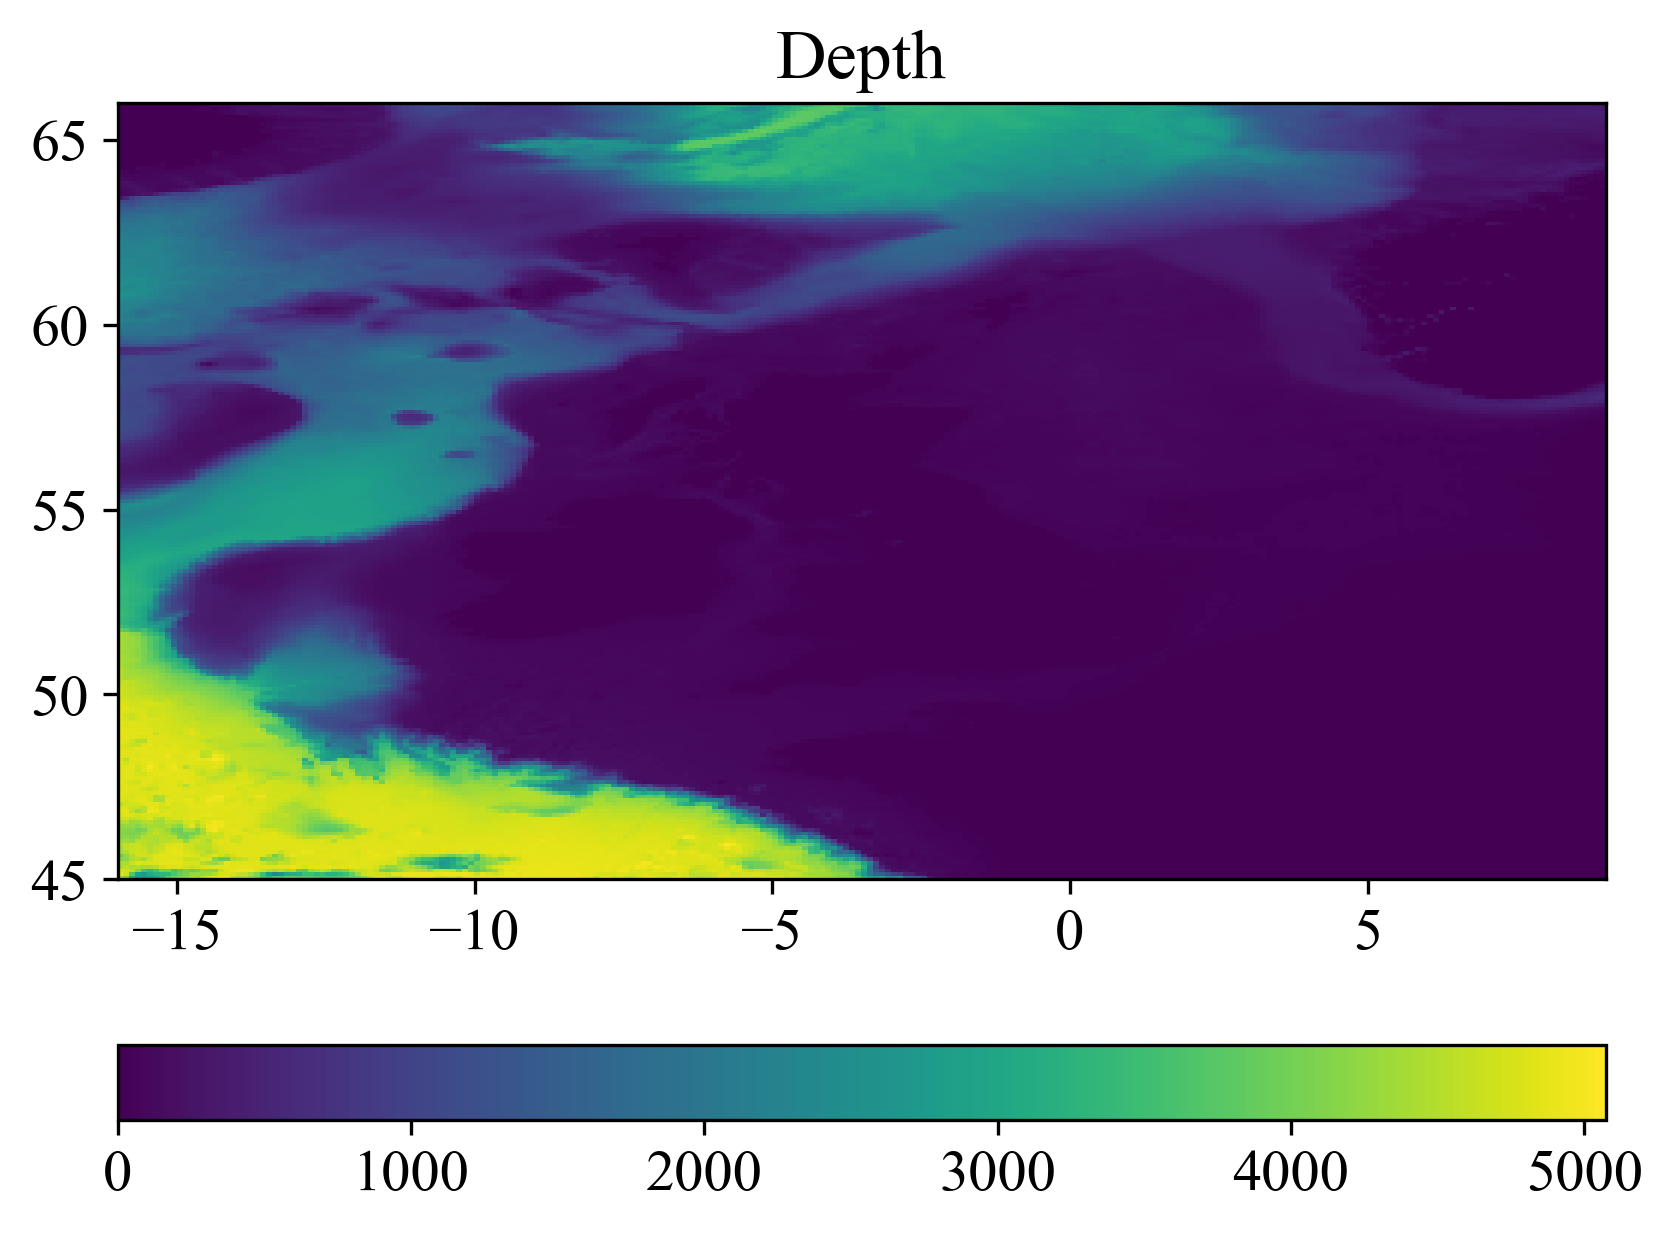

size(b) = (251, 211)


In [5]:
bx, by, b = load_bath(bathname, true, longrid, latgrid)
@show size(b)

if doplot
    fig = PyPlot.figure()
    ax = PyPlot.subplot(111)
    pcolor(bx,by,b', vmin=0.); 
    colorbar(orientation="horizontal")
    title("Depth")
    show()
end

### Metrics

In [6]:
mask, (pm, pn),(xi, yi) = DIVAnd.DIVAnd_rectdom(longrid, latgrid);
xi, yi, mask = DIVAnd.load_mask(bathname, true, longrid, latgrid, 0.0);
xx, yy = ndgrid(xi, yi);

## Interpolation

In [7]:
function read_coords_species(datafile::String, species::Union{String,SubString{String}})
    data = readdlm(datafile, ',');
    colnames = data[1,:]
    dates = data[2:end,2]
    lon = data[2:end,3]
    lat = data[2:end,4]
    col_index = findall(colnames .== species)[1]
    @info("Column index for $(species): $(col_index)");
    occur_species = data[2:end,col_index]
    occur_pre = findall(occur_species .== "TRUE")
    occur_abs = findall(occur_species .== "FALSE")
    lon_presence = lon[occur_pre]
    lat_presence = lat[occur_pre]
    lon_absence = lon[occur_abs]
    lat_absence = lat[occur_abs];
    return Float64.(lon_presence), Float64.(lat_presence), Float64.(lon_absence), Float64.(lat_absence)
end

read_coords_species (generic function with 1 method)

In [8]:
species = "Abludomelita_obtusata"
@time lon_pre, lat_pre, lon_abs, lat_abs = read_coords_species(datafile, species);
# Test
length(lon_pre) == 2097
length(lat_abs) == 66463

┌ Info: Column index for Abludomelita_obtusata: 9
└ @ Main In[7]:8


  2.819764 seconds (10.86 M allocations: 417.729 MiB, 15.67% gc time)


true

### Compute heatmaps

In [10]:
@time dens2, LHM2, LCV2, LSCV2 = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon_pre, lat_pre), ones(length(lat_pre)), 0.2);
@time dens3, LHM3, LCV3, LSCV3 = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon_abs, lat_abs), ones(length(lat_abs)), 0.2);

 69.412998 seconds (57.47 M allocations: 16.333 GiB, 3.26% gc time)


┌ Warning: Data array size (66463,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 43.417283 seconds (2.58 M allocations: 12.759 GiB, 0.83% gc time)


Finally, the probability field is computed as:
```
d = npre * dens2 / (npre * dens2 + nabs * dens3)
```
The reason for this equation is that the heatmap are computed so that their integral over the domain is 1, whatever the number of observations. 

In [11]:
npre = length(lon_pre)
nabs = length(lon_abs)
d = npre .* dens2 ./ (npre .* dens2 .+ nabs .* dens3);

### Plotting

In [12]:
function plot_heatmap2(longrid::StepRangeLen, latgrid::StepRangeLen,
    dens::Array, lonpre::Vector, latpre::Vector, lonabs::Vector, latabs::Vector,
    titletext::String, figname::String="", vmin=0., vmax=1.0)

    llon, llat = ndgrid(longrid, latgrid)
    myproj = ccrs.PlateCarree()
    fig = PyPlot.figure(figsize=(12,8))
    ax = PyPlot.subplot(111, projection=myproj)
    ax.plot(lonpre, latpre, "wo", markersize=1., zorder=3, alpha=.25)
    ax.plot(lonabs, latabs, "ko", markersize=1., zorder=3, alpha=.25)
    pcm = ax.pcolor(llon, llat, dens, cmap=PyPlot.cm.hot_r, zorder=2, vmin=vmin, vmax=vmax)
    colorbar(pcm, orientation="vertical")
    decorate_map_domain(ax, dlon=4.)
    title(titletext)
    if length(figname) > 0
        PyPlot.savefig(figname, dpi=300, bbox_inches="tight")
        PyPlot.close()
    else
        PyPlot.show()
    end
end

plot_heatmap2 (generic function with 4 methods)

In [13]:
function plot_error2(longrid::StepRangeLen, latgrid::StepRangeLen,
    error::Array, titletext::String="", figname::String="")

    llon, llat = ndgrid(longrid, latgrid)
    myproj = ccrs.PlateCarree()
    fig = PyPlot.figure(figsize=(12,8))
    ax = PyPlot.subplot(111, projection=myproj)
    pcm = ax.pcolor(llon, llat, error, zorder=2, cmap=PyPlot.cm.RdYlGn_r)
    colorbar(pcm, orientation="vertical")
    decorate_map_domain(ax, dlon=4.)
    title(titletext)
    if length(figname) > 0
        PyPlot.savefig(figname, dpi=300, bbox_inches="tight")
        PyPlot.close()
    else
        PyPlot.show()
    end
end

plot_error2 (generic function with 3 methods)

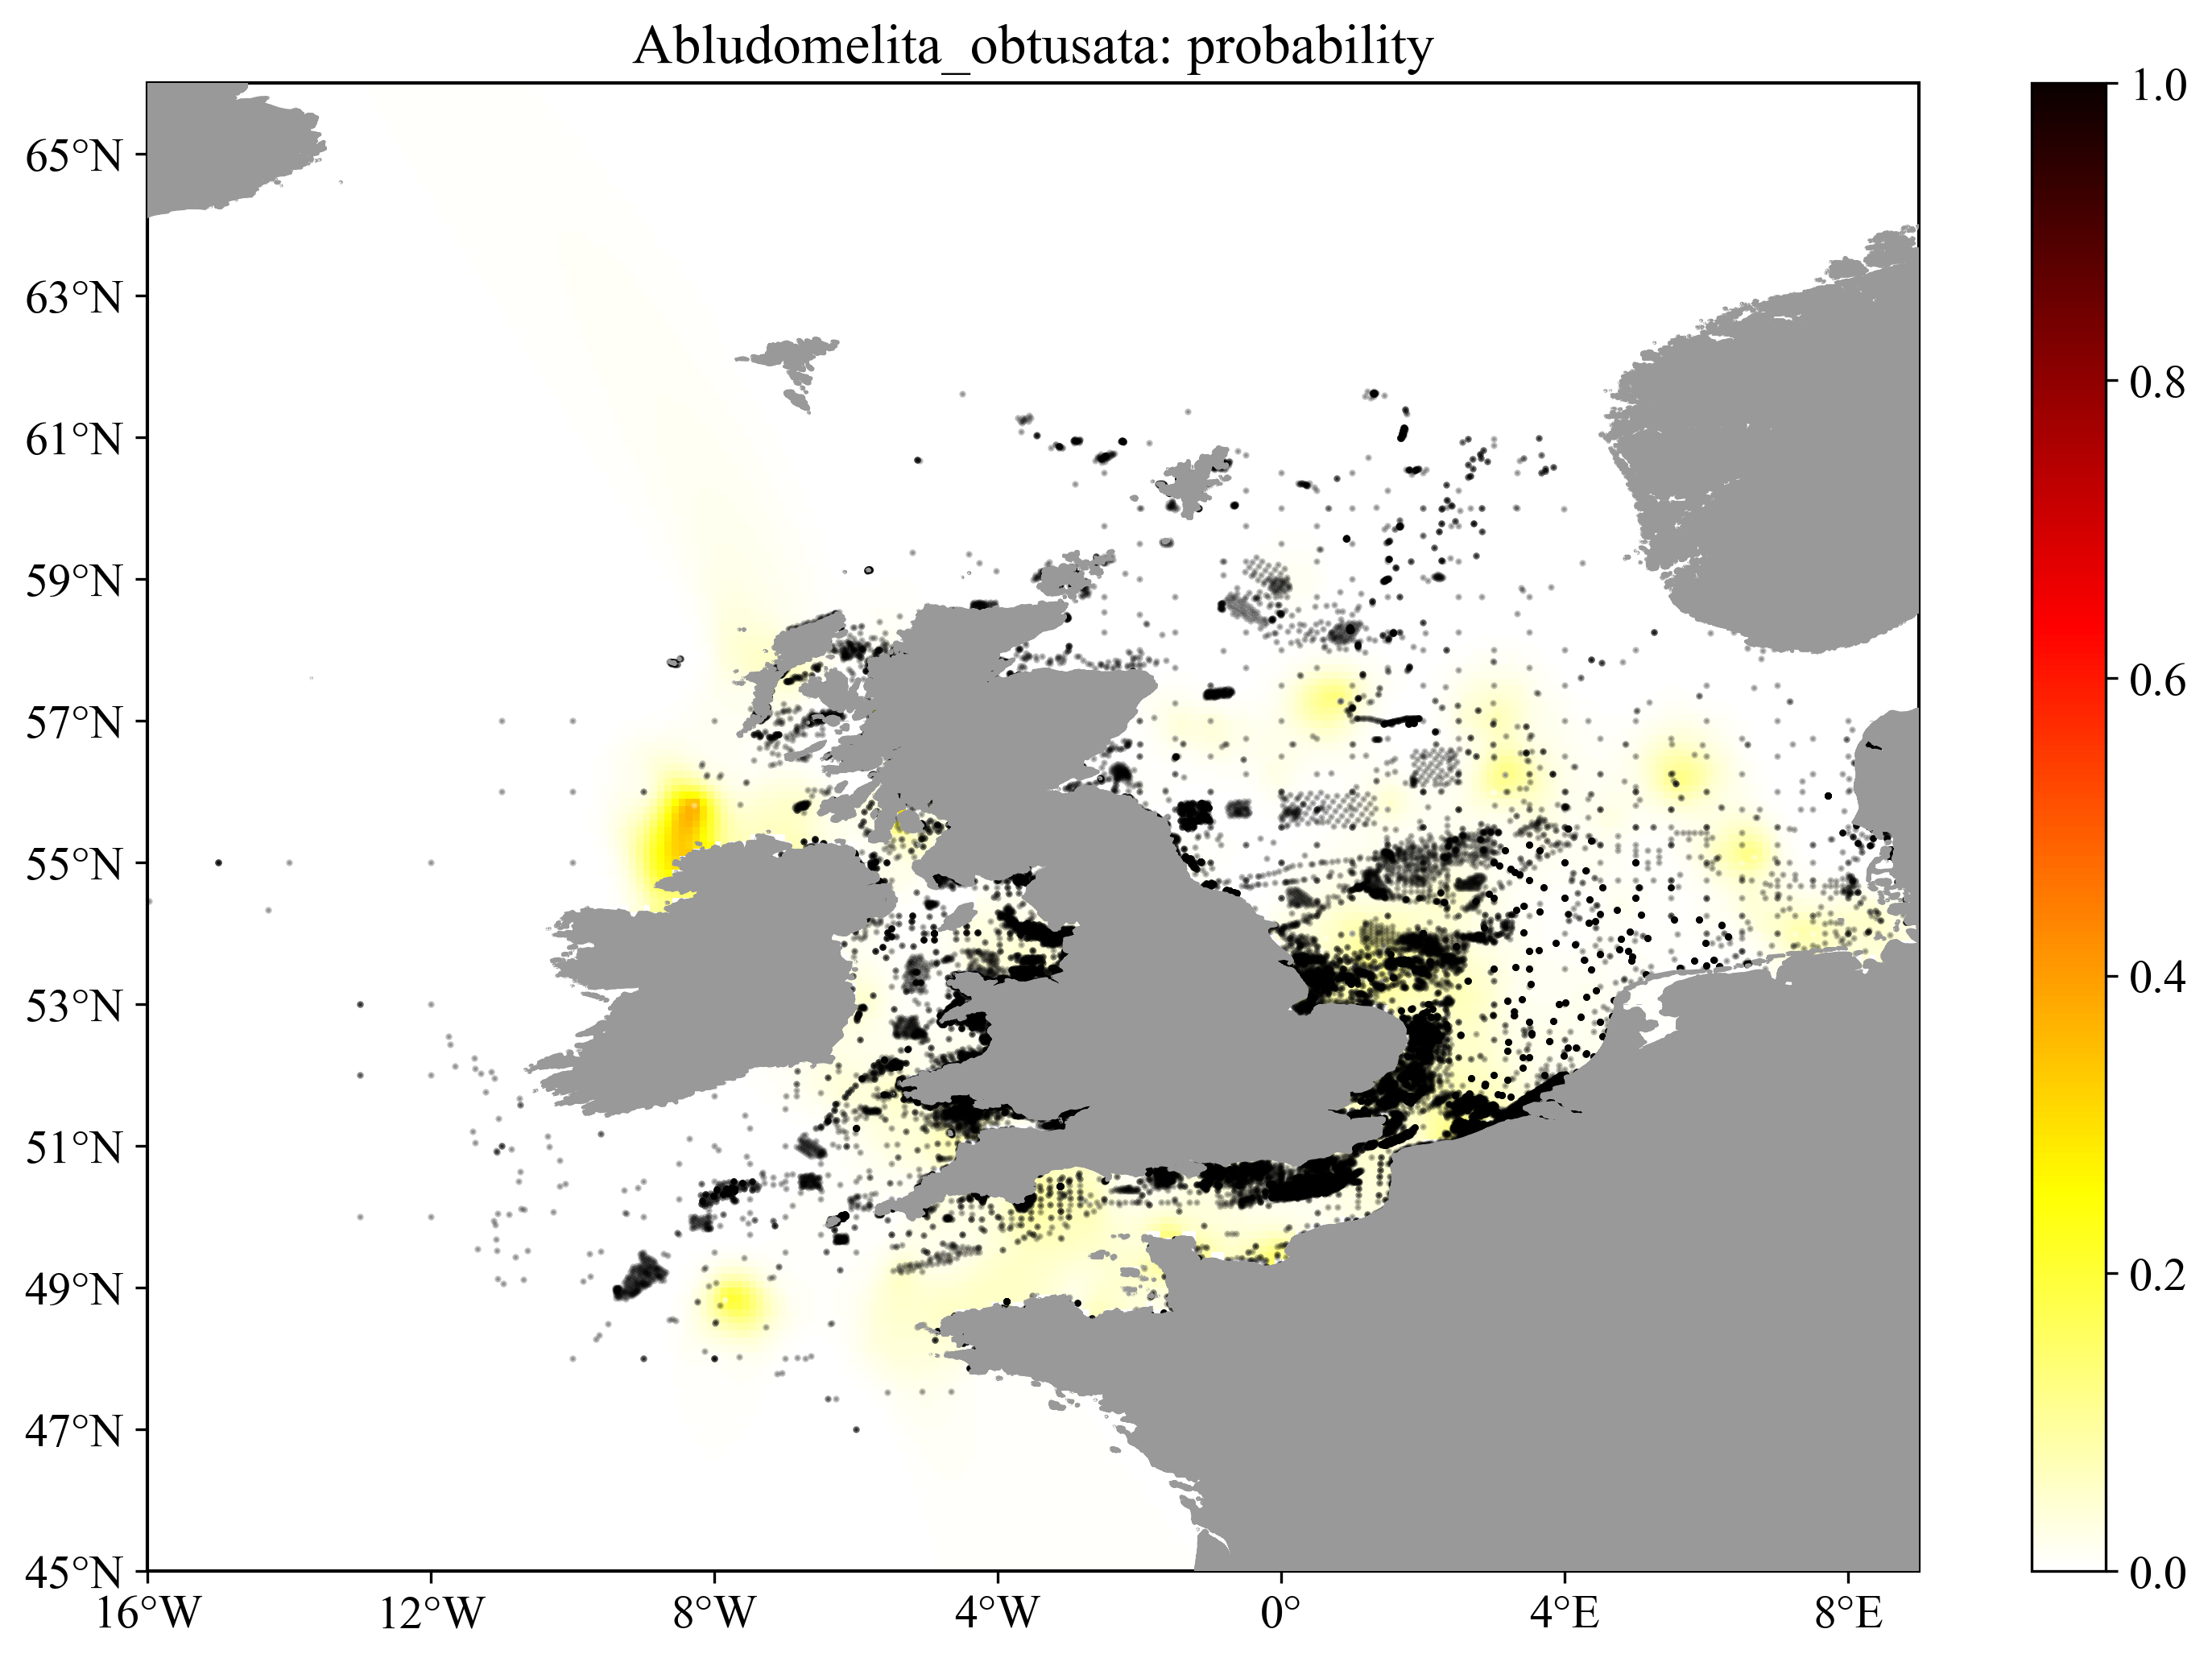

In [14]:
if doplot
    plot_heatmap2(longrid, latgrid, d, lon_pre, lat_pre, lon_abs, lat_abs,
        "$(species): probability")
    #pcolormesh(longrid, latgrid, mask', cmap=PyPlot.cm.binary_r)
end

## Loop on all the files

In [15]:
function get_species_names(datafile::String)::Array
    firstline = []
    open(datafile, "r") do df
        firstline = readline(df)
    end
    return split(firstline, ",")[5:end]
end

get_species_names (generic function with 1 method)

In [16]:
speciesnamelist = get_species_names(datafile)

for species in speciesnamelist
    
    speciesslug = get_species_slug(String(species))
    @info(speciesslug)
    @info("Working on species $(species)");
    lon_pre, lat_pre, lon_abs, lat_abs = read_coords_species(datafile, species);
    
    @time dens2, LHM2, LCV2, LSCV2 = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon_pre, lat_pre), ones(length(lat_pre)), 0.5);
    @time dens3, LHM3, LCV3, LSCV3 = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon_abs, lat_abs), ones(length(lat_abs)), 0.5);
    
    npre = length(lon_pre)
    nabs = length(lon_abs)
    d = npre .* dens2 ./ (npre .* dens2 .+ nabs .* dens3);
    
    @info("Computing error field with CPME")
    lon = [lon_pre ; lon_abs]
    lat = [lat_pre ; lat_abs]
    
    cpme = DIVAnd_cpme(mask, (pm, pn), (xx, yy), (lon, lat), 
        ones(length(lon)), 0.5, 5.);
    
    if doplot
    plot_heatmap2(longrid, latgrid, d, lon_pre, lat_pre, lon_abs, lat_abs,
        "$(species): probability", joinpath(figdir, "$(speciesslug)_density.png"))
    end
    
    if doplot
        plot_error2(longrid, latgrid, cpme, "$(species)", 
            joinpath(figdir, "$(speciesslug)_error.png"))
    end   
    
    create_nc_results(joinpath(outputdir, "$(speciesslug)_density.nc"), 
        longrid, latgrid, d, String(species));
    
    # Add the error field
    write_nc_error(joinpath(outputdir, "$(speciesslug)_density.nc"), cpme);
end

┌ Info: Abra_alba
└ @ Main In[16]:6
┌ Info: Working on species Abra_alba
└ @ Main In[16]:7
┌ Info: Column index for Abra_alba: 5
└ @ Main In[7]:8
┌ Warning: Data array size (14068,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 16.202191 seconds (505.75 k allocations: 6.264 GiB, 0.96% gc time)


┌ Warning: Data array size (65977,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 32.223054 seconds (2.15 M allocations: 12.477 GiB, 2.47% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[16]:19
┌ Info: Amphiura_filiformis
└ @ Main In[16]:6
┌ Info: Working on species Amphiura_filiformis
└ @ Main In[16]:7
┌ Info: Column index for Amphiura_filiformis: 6
└ @ Main In[7]:8


116.458989 seconds (507.80 k allocations: 36.071 GiB, 0.68% gc time)


┌ Warning: Data array size (74293,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 33.328799 seconds (2.38 M allocations: 11.184 GiB, 1.92% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[16]:19
┌ Info: Diplocirrus_glaucus
└ @ Main In[16]:6
┌ Info: Working on species Diplocirrus_glaucus
└ @ Main In[16]:7
┌ Info: Column index for Diplocirrus_glaucus: 7
└ @ Main In[7]:8


 79.674252 seconds (363.47 k allocations: 25.856 GiB, 1.51% gc time)


┌ Warning: Data array size (64473,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 36.705574 seconds (2.10 M allocations: 11.888 GiB, 2.18% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[16]:19
┌ Info: Amphiura_chiajei
└ @ Main In[16]:6
┌ Info: Working on species Amphiura_chiajei
└ @ Main In[16]:7
┌ Info: Column index for Amphiura_chiajei: 8
└ @ Main In[7]:8


 45.688239 seconds (155.30 k allocations: 11.262 GiB, 1.64% gc time)


┌ Warning: Data array size (66785,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 37.303133 seconds (2.17 M allocations: 12.411 GiB, 0.93% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[16]:19
┌ Info: Abludomelita_obtusata
└ @ Main In[16]:6
┌ Info: Working on species Abludomelita_obtusata
└ @ Main In[16]:7
┌ Info: Column index for Abludomelita_obtusata: 9
└ @ Main In[7]:8


 45.434341 seconds (188.59 k allocations: 13.588 GiB, 1.87% gc time)


┌ Warning: Data array size (66463,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 44.965905 seconds (2.17 M allocations: 12.739 GiB, 0.76% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[16]:19
┌ Info: Bicellariella_ciliata
└ @ Main In[16]:6
┌ Info: Working on species Bicellariella_ciliata
└ @ Main In[16]:7
┌ Info: Column index for Bicellariella_ciliata: 10
└ @ Main In[7]:8


 39.954013 seconds (194.30 k allocations: 13.995 GiB, 2.14% gc time)


┌ Warning: Data array size (66401,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 42.138030 seconds (2.17 M allocations: 12.772 GiB, 0.78% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[16]:19
┌ Info: Megaluropus_agilis
└ @ Main In[16]:6
┌ Info: Working on species Megaluropus_agilis
└ @ Main In[16]:7
┌ Info: Column index for Megaluropus_agilis: 11
└ @ Main In[7]:8


 36.073176 seconds (171.07 k allocations: 12.499 GiB, 2.29% gc time)


┌ Warning: Data array size (66641,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 38.624930 seconds (2.17 M allocations: 12.758 GiB, 0.86% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[16]:19
┌ Info: Sigalion_mathildae
└ @ Main In[16]:6
┌ Info: Working on species Sigalion_mathildae
└ @ Main In[16]:7
┌ Info: Column index for Sigalion_mathildae: 12
└ @ Main In[7]:8


 41.621848 seconds (166.12 k allocations: 12.144 GiB, 1.88% gc time)


┌ Warning: Data array size (66697,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 37.850361 seconds (2.17 M allocations: 12.709 GiB, 0.84% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[16]:19
┌ Info: Callianassa_subterranea
└ @ Main In[16]:6
┌ Info: Working on species Callianassa_subterranea
└ @ Main In[16]:7
┌ Info: Column index for Callianassa_subterranea: 13
└ @ Main In[7]:8


 45.960458 seconds (189.67 k allocations: 13.669 GiB, 1.75% gc time)


┌ Warning: Data array size (67049,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 42.398659 seconds (2.19 M allocations: 12.717 GiB, 0.88% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[16]:19
┌ Info: Acrocnida_brachiata
└ @ Main In[16]:6
┌ Info: Working on species Acrocnida_brachiata
└ @ Main In[16]:7
┌ Info: Column index for Acrocnida_brachiata: 14
└ @ Main In[7]:8


 39.127033 seconds (148.66 k allocations: 10.900 GiB, 1.95% gc time)


┌ Warning: Data array size (66895,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 38.252570 seconds (2.18 M allocations: 12.608 GiB, 0.92% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[16]:19
┌ Info: Littorina_littorea
└ @ Main In[16]:6
┌ Info: Working on species Littorina_littorea
└ @ Main In[16]:7
┌ Info: Column index for Littorina_littorea: 15
└ @ Main In[7]:8


 28.415560 seconds (113.16 k allocations: 8.299 GiB, 2.36% gc time)


┌ Warning: Data array size (67275,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 44.282585 seconds (2.19 M allocations: 12.797 GiB, 0.76% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[16]:19
┌ Info: Aequipecten_opercularis
└ @ Main In[16]:6
┌ Info: Working on species Aequipecten_opercularis
└ @ Main In[16]:7
┌ Info: Column index for Aequipecten_opercularis: 16
└ @ Main In[7]:8


 38.128823 seconds (170.33 k allocations: 12.409 GiB, 2.14% gc time)


┌ Warning: Data array size (78087,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 35.828530 seconds (2.52 M allocations: 12.609 GiB, 0.90% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[16]:19
┌ Info: Bathyporeia_tenuipes
└ @ Main In[16]:6
┌ Info: Working on species Bathyporeia_tenuipes
└ @ Main In[16]:7
┌ Info: Column index for Bathyporeia_tenuipes: 17
└ @ Main In[7]:8


 29.081660 seconds (127.24 k allocations: 9.377 GiB, 2.45% gc time)


┌ Warning: Data array size (67139,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 39.093189 seconds (2.19 M allocations: 12.608 GiB, 0.80% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[16]:19
┌ Info: Lumbrineriopsis_paradoxa
└ @ Main In[16]:6
┌ Info: Working on species Lumbrineriopsis_paradoxa
└ @ Main In[16]:7
┌ Info: Column index for Lumbrineriopsis_paradoxa: 18
└ @ Main In[7]:8


 40.111866 seconds (191.61 k allocations: 13.808 GiB, 2.06% gc time)


┌ Warning: Data array size (66432,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 40.524754 seconds (2.17 M allocations: 12.797 GiB, 0.80% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[16]:19
┌ Info: Spio_armata
└ @ Main In[16]:6
┌ Info: Working on species Spio_armata
└ @ Main In[16]:7
┌ Info: Column index for Spio_armata: 19
└ @ Main In[7]:8


 52.438227 seconds (163.82 k allocations: 11.974 GiB, 1.61% gc time)


┌ Warning: Data array size (66721,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 49.060129 seconds (2.18 M allocations: 12.784 GiB, 0.63% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[16]:19
┌ Info: Schizomavella_(Schizomavella)_auriculata
└ @ Main In[16]:6
┌ Info: Working on species Schizomavella_(Schizomavella)_auriculata
└ @ Main In[16]:7
┌ Info: Column index for Schizomavella_(Schizomavella)_auriculata: 20
└ @ Main In[7]:8


 27.752411 seconds (125.79 k allocations: 9.273 GiB, 0.98% gc time)


┌ Warning: Data array size (67155,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 43.301011 seconds (2.19 M allocations: 12.778 GiB, 1.55% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[16]:19
┌ Info: Amphiura_(Ophiopeltis)_securigera
└ @ Main In[16]:6
┌ Info: Working on species Amphiura_(Ophiopeltis)_securigera
└ @ Main In[16]:7
┌ Info: Column index for Amphiura_(Ophiopeltis)_securigera: 21
└ @ Main In[7]:8


 25.964637 seconds (117.47 k allocations: 8.682 GiB, 2.42% gc time)


┌ Warning: Data array size (67250,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 39.501995 seconds (2.19 M allocations: 12.804 GiB, 1.91% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[16]:19
┌ Info: Diplocirrus_stopbowitzi
└ @ Main In[16]:6
┌ Info: Working on species Diplocirrus_stopbowitzi
└ @ Main In[16]:7
┌ Info: Column index for Diplocirrus_stopbowitzi: 22
└ @ Main In[7]:8


  7.020441 seconds (31.75 k allocations: 2.567 GiB, 0.91% gc time)


┌ Warning: Data array size (68228,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 45.114059 seconds (2.22 M allocations: 12.810 GiB, 1.75% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[16]:19
